In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [4]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        
        # YOUR TASK: ADD EMBEDDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.user_embedding_gmf = nn.Embedding(nb_users, mf_dim)
        self.item_embedding_gmf = nn.Embedding(nb_items, mf_dim)
        self.user_embedding_mlp = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.item_embedding_mlp = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        
        # YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        mlp_layers = []
        for i in range(len(mlp_layer_sizes) - 1):
            mlp_layers.append(nn.Linear(mlp_layer_sizes[i], mlp_layer_sizes[i + 1]))
            mlp_layers.append(nn.ReLU())
            if dropout > 0:
                mlp_layers.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*mlp_layers)
        
        self.final = nn.Linear(mf_dim + mlp_layer_sizes[-1], 1)
        
        # YOUR TASK: Initialize weights ~4 lines of code - use glorot (final MLP has to use lecunn
        self._init_weights()

    def _init_weights(self):
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        
        self.user_embedding_gmf.weight.data.uniform_(-0.1, 0.1)
        self.item_embedding_gmf.weight.data.uniform_(-0.1, 0.1)
        self.user_embedding_mlp.weight.data.uniform_(-0.1, 0.1)
        self.item_embedding_mlp.weight.data.uniform_(-0.1, 0.1)

        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        # YOUR TASK: Implement model forward. ~15 lines of code
        # GMF part
        user_gmf = self.user_embedding_gmf(user)
        item_gmf = self.item_embedding_gmf(item)
        gmf_output = user_gmf * item_gmf
        
        # MLP part
        user_mlp = self.user_embedding_mlp(user)
        item_mlp = self.item_embedding_mlp(item)
        mlp_input = torch.cat([user_mlp, item_mlp], dim=1)
        mlp_output = self.mlp(mlp_input)
        
        # Concatenate GMF and MLP outputs
        output = torch.cat([gmf_output, mlp_output], dim=1)
        output = self.final(output)
        
        if sigmoid:
            output = torch.sigmoid(output)
        
        return output

# Test the forward method
nb_users = 1000
nb_items = 1700
mf_dim = 8
mlp_layer_sizes = [16, 32, 16, 8]
dropout = 0.2

model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes, dropout)

# Generate some random user and item IDs
user_ids = torch.LongTensor([1, 2, 3])
item_ids = torch.LongTensor([4, 5, 6])

# Forward pass
output = model(user_ids, item_ids, sigmoid=True)
print(output)


tensor([[0.4283],
        [0.4683],
        [0.4333]], grad_fn=<SigmoidBackward0>)


### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [5]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this! store them in self.users,self.items,self.labels
        #Sample neg users
        self.users = []
        self.items = []
        self.labels = []
        #sample neg items

        for user, item in ratings:
            self.users.append(user.item())
            self.items.append(item.item())
            self.labels.append(1)

        # Negative samples
        user_item_set = set(zip(ratings_df['user_id'], ratings_df['item_id']))
        all_items = set(range(1, max_item + 1))
        
        for user, item in ratings:
            for _ in range(negative_samples):
                neg_item = np.random.choice(list(all_items - set(ratings_df[ratings_df['user_id'] == user.item()]['item_id'])))
                self.users.append(user.item())
                self.items.append(neg_item)
                self.labels.append(0)

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [6]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, device):
    train_loss = []
    test_loss = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for users, items, labels in tqdm_notebook(train_loader, leave=False):
            users, items, labels = users.to(device), items.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(users, items, sigmoid=True).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * users.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_loss.append(epoch_train_loss)
        
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for users, items, labels in test_loader:
                users, items, labels = users.to(device), items.to(device), labels.to(device).float()
                outputs = model(users, items, sigmoid=True).squeeze()
                loss = criterion(outputs, labels)
                
                running_test_loss += loss.item() * users.size(0)
        
        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_loss.append(epoch_test_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')
    
    return train_loss, test_loss

# Hyperparameters
nb_users = 1000
nb_items = 1700
mf_dim = 8
mlp_layer_sizes = [16, 32, 16, 8]
dropout = 0.2
learning_rate = 0.001
batch_size = 256
epochs = 20

# Prepare data
train_dataset = ML100kDataset('ml-100k/u1.base', negative_samples=4)
test_dataset = ML100kDataset('ml-100k/u1.test', negative_samples=0)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, criterion, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes, dropout).to(device)
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train and plot
train_loss, test_loss = train_model(model, train_loader, test_loader, criterion, optimizer, epochs, device)


/tmp/ipykernel_36/1888719100.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for users, items, labels in tqdm_notebook(train_loader, leave=False):


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.1303, Test Loss: 0.4126


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.1080, Test Loss: 0.3706


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.0954, Test Loss: 0.3409


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.0898, Test Loss: 0.3384


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.0863, Test Loss: 0.3557


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.0838, Test Loss: 0.3304


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.0820, Test Loss: 0.3459


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.0804, Test Loss: 0.3338


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.0790, Test Loss: 0.3457


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.0781, Test Loss: 0.3455


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.0772, Test Loss: 0.3417


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.0763, Test Loss: 0.3401


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.0756, Test Loss: 0.3261


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.0749, Test Loss: 0.3390


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.0743, Test Loss: 0.3351


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.0737, Test Loss: 0.3463


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.0732, Test Loss: 0.3368


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.0728, Test Loss: 0.3444


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.0722, Test Loss: 0.3503


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.0717, Test Loss: 0.3614


### Plot results

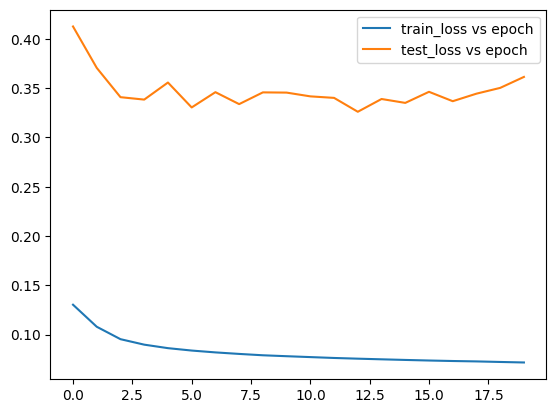

In [7]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.show()